# Gauge transformation of the gauge links in a LC coordinate lattice

## Step 1

We write the relevant gauge link in a $(x^+, x^-, y)$ lattice

In [3]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = 'su3'

import curraun.su as su
import numpy as np
import pickle

Using SU(3)
Using Numba
Using double precision


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# We read the fields

fields = np.load('gauge_links_fields_glasma_test.npz')
ux = fields['ux']

with open('parameters_gauge_transf_glasma_test.pickle', 'rb') as f:
    param = pickle.load(f)

In [5]:
print(np.shape(ux))

(64, 16384, 9)


In [6]:
# We get the relevant parameters

N = param['N']
Dg = param['DG']

t_steps = np.shape(ux)[0]

In [7]:
# We reshape the transverse component into a N*N matrix

ux_r = ux.reshape((t_steps, N, N, Dg))

print(np.shape(ux_r))

(64, 128, 128, 9)


In [8]:
# We define a function that takes a Milne lattice functions and puts it in the LC lattice

def change_lattice(u):
    u_LC = su.GROUP_TYPE(np.zeros((t_steps//2, t_steps//2, N, Dg)))

    for i in range(t_steps//2):
        for j in range(t_steps//2):
            u_LC[i,j,:,:] = u[i+j,i-j+N//2,:,:]
    
    return u_LC

In [9]:
# We transform the Ux links to the LC coordinates

ux_LC = change_lattice(ux_r)

print(np.shape(ux_LC))

(32, 32, 128, 9)


In [10]:
# We get the plus and minus direction links

uminus = np.apply_along_axis(su.dagger, 3, ux_LC)
uplus = ux_LC

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 347:
@myjit
def dagger(a):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


## Step 2

We gauge transform the field in the LC lattice

In [36]:
# We write the gauge transformation operator at a given (x^+, x^-) point

def gauge_operator(u, xplus): #The input has to be written in the Milne lattice (TODO: writte the input in LC lattice ?)
    buffer1 = np.array([su.unit() for j in range(N)])
    v = su.GROUP_TYPE(np.zeros((t_steps//2, N, Dg)))
    
    for i in range(-xplus, t_steps//2):
        buffer2 = ux_r[xplus + i, xplus-i+N//2, :, :]
        r = np.array([su.mul(buffer1[j, :], buffer2[j, :]) for j in range(N)])
        
        if i>0:
            v[i, :, :] = r
        buffer1 = r
    result = np.apply_along_axis(su.dagger, 2, v)
    return result

In [37]:
# We create a matrix that contains the gauge transformation operator at every point

v_LC = su.GROUP_TYPE(np.zeros((t_steps//2, t_steps//2, N, Dg)))

for k in range(t_steps//2):
    v_LC[k,:,:,:] = gauge_operator(ux_r, k)

In [38]:
print(np.shape(v_LC))
print(v_LC[1,1,1,:])

(32, 32, 128, 9)
[ 6.97102818e-01+0.0500605j   7.57575918e-02-0.50278093j
  4.73607538e-01-0.16943916j -5.86482335e-02-0.59164718j
  8.03577718e-01-0.02345545j  8.01119721e-04+0.0150348j
 -3.68986293e-01-0.14800243j -1.27830262e-01+0.28079216j
  8.63262455e-01-0.03921119j]


In [39]:
# We define a function that performs the gauge transformation trough a given axis

def gauge_transform(u, v, comp): # comp = 0 for + component and comp = 1 for - component
    buffer1 = np.array([[[su.mul(v[t, i, j, :], u[t, i, j, :]) for j in range (N)] for i in range (t_steps//2)] for t in range (t_steps//2)])
    
    if comp == 0:
        result =  np.array([[[su.mul(buffer1[t, i, j, :], su.dagger(v[t, i, j, :])) for j in range (N)] for i in range (t_steps//2)] for t in range (t_steps//2 )])
    
    elif comp == 1:
        result =  np.array([[[su.mul(buffer1[t, i, j, :], su.dagger(v[t, i, j, :])) for j in range (N)] for i in range (t_steps//2)] for t in range (t_steps//2)])
    
    else:
        raise TypeError("comp must be 0 for + component or 1 for - component")
    
    return result

In [40]:
#We gauge transform the plus and minus components

uplus_trans = gauge_transform(uplus, v_LC, 0)
uminus_trans = gauge_transform(uminus, v_LC, 1)

In [41]:
print(uplus_trans[2,2,2,:])

[ 0.96750576-0.00691776j -0.01041211+0.22191686j -0.10751308+0.05449941j
  0.01205309+0.21482048j  0.97416567-0.0036508j  -0.03659863-0.05792538j
  0.11777227+0.06100269j  0.02280665-0.03335083j  0.99028342+0.01070927j]


In [42]:
uplus_LC_r = uplus_trans.reshape((t_steps//2, t_steps//2, N, 3, 3))
uminus_LC_r = uminus_trans.reshape((t_steps//2, t_steps//2, N, 3, 3))

print(uplus_LC_r[2,2,2,:,:])

[[ 0.96750576-0.00691776j -0.01041211+0.22191686j -0.10751308+0.05449941j]
 [ 0.01205309+0.21482048j  0.97416567-0.0036508j  -0.03659863-0.05792538j]
 [ 0.11777227+0.06100269j  0.02280665-0.03335083j  0.99028342+0.01070927j]]


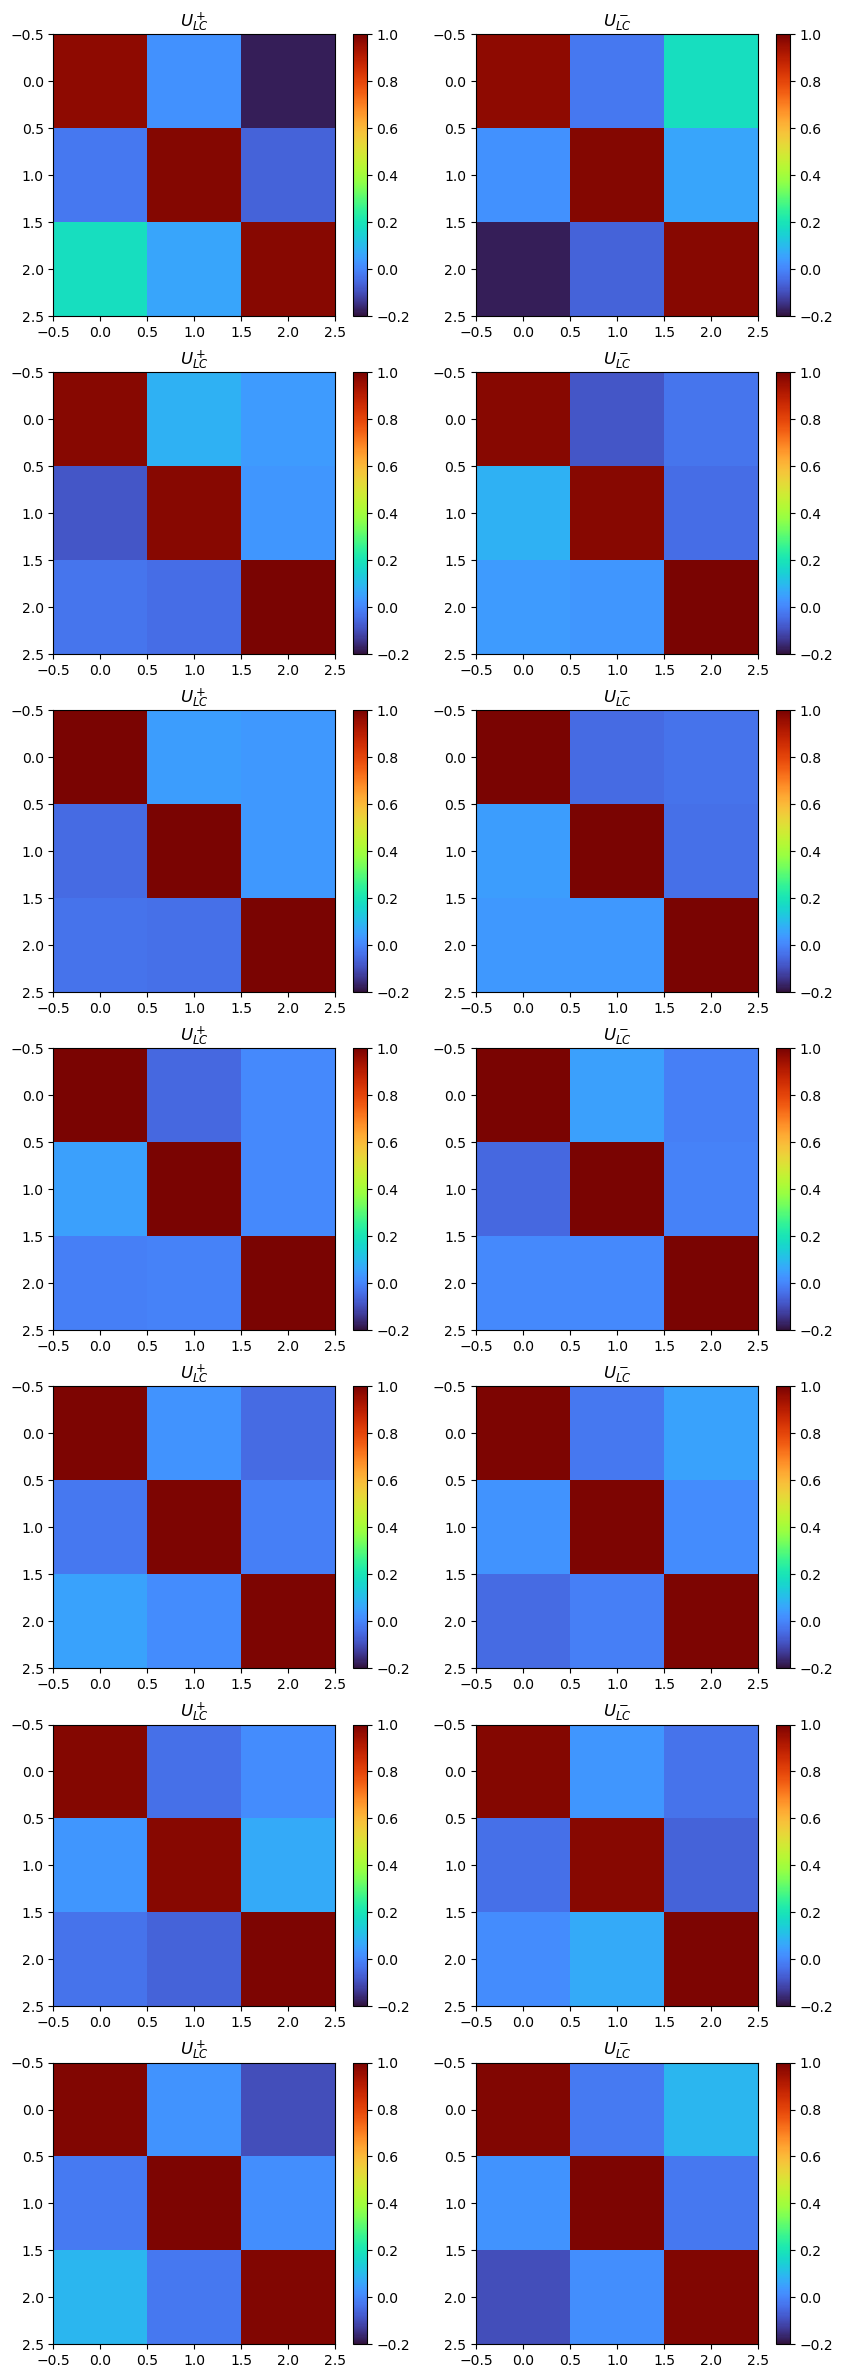

In [43]:
# We check that the transformed U^+ is the unity

import matplotlib.pyplot as plt 

fig, axs = plt.subplots(t_steps//10 +1, 2, figsize=(10,30))
xminus = 2; y = 2

for t in range(t_steps//10 + 1): 
    xplus = 5*t
    plot1 = axs[t,0].imshow(uplus_LC_r[xplus, xminus, y, :, :].real, cmap='turbo', vmin=-0.2, vmax=1) 
    axs[t,0].set_title(r'$U^+_{LC}$')
    plt.colorbar(plot1, ax = axs[t,0])
    
    plot1 = axs[t, 1].imshow(uminus_LC_r[xplus, xminus, y, :, :].real, cmap='turbo', vmin=-0.2, vmax=1)
    axs[t,1].set_title(r'$U^-_{LC}$')
    plt.colorbar(plot1, ax = axs[t,1])

In [19]:
print(uminus_trans[2,2,2,:])

[ 9.72781150e-01+0.03853819j  4.04098540e-03-0.18393111j
  1.32479897e-01-0.02852608j  1.98324155e-04-0.1987056j
  9.74369172e-01-0.01061859j  3.33065326e-02+0.09949213j
 -1.10347132e-01-0.02347762j -3.42077378e-02+0.12439779j
  9.84804524e-01-0.0280603j ]
